In [1]:
import mne 
import os
import mne 
from mne.io import  read_raw_edf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
data_folder ='data/'

In [22]:
data_folder = "data/"
freq = 80
q = 256/freq

# Set the path to the patient folder
data_files = sorted([f for f in os.listdir(data_folder) if f.startswith('chb')])
# Define the list of channels to keep
# channels_to_keep = ['FP1-F7', 'FP1-F3', 'FP2-F4', 'F8-T8','FP2-F8', 'T8-P8-1', 'T8-P8-0', 'P8-O2', 'P4-O2']# 
#channels_to_keep = ['FP1-F7', 'FP1-F3']# 
dataframes = []  # List to store individual DataFrames

for folder_list in range(1,len(data_files[:5])):  # Assumes folders are named ch01 to ch10
        folder_name = f'chb{folder_list:02d}'  # Format the folder name as ch01, ch02, etc.
        folder_path = os.path.join(data_folder,folder_name)  # Create the full path to the folder

        # Create an empty list to store raw data
        patient_raws = []

        # Create an empty list to store file names
        file_names = []

        # Get a list of .edf files sorted by filename numbers
        edf_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.edf')])

        # Read the first .edf file to obtain the channel information
        first_file_path = os.path.join(folder_path, edf_files[0])
        first_raw = mne.io.read_raw_edf(first_file_path, preload=False, verbose="ERROR")
        #first_raw.pick_channels(channels_to_keep)

        # Loop through the sorted .edf files
        for file in edf_files:
            file_path = os.path.join(folder_path, file)
            raw = mne.io.read_raw_edf(file_path, preload=False, verbose="ERROR")
            #Keep only the specified channels
            #raw.pick_channels(channels_to_keep)
            raw_time_df = raw.to_data_frame()
            new_time = raw_time_df["time"].iloc[::2].reset_index()
            #raw_time_df = raw_time_df["time"]
            raw2 = raw.resample(sfreq=freq)

            # Set the channel information for each Raw object to match the first Raw object
            raw2.info = first_raw.info
            raw_df = raw2.to_data_frame()
            raw_df["file_name"] = file
            raw_df["original_time"] = new_time["time"]
            patient_raws.append(raw_df)
            #file_names.extend([file] * len(raw.times))

        # Concatenate the raw objects into a single patient_combined object while maintaining a continuous time axis
        #patient_combined = mne.concatenate_raws(patient_raws, preload=False)
        patient_combined = pd.concat(patient_raws, ignore_index=True)
        # Print info about the combined raw object for this patient
        #print(patient_combined.info)

        #df = patient_combined.to_data_frame()
        #df['file_name'] = file_names
        dataframes.append(patient_combined)
# Concatenate all DataFrames into a single DataFrame
final_dataframe = pd.concat(dataframes, ignore_index=True)

In [5]:
def get_seizure_sequence(source_path="data"):
    all_data = []

    for folder_name in os.listdir(source_path):
        folder_path = os.path.join(source_path, folder_name)

        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(".txt"):
                    file_path = os.path.join(folder_path, filename)
                    source_file = filename.split("-")[0]
                    data = []
                    current_data = {"File Name": None, "Number of Seizures": None, "Seizure Start Time": np.nan, "Seizure End Time": np.nan, "Source File": source_file}
                    with open(file_path, "r") as file:
                        for line in file:
                            line = line.strip()
                            if line.startswith("File Name:"):
                                current_data = {"File Name": None, "Number of Seizures": None, "Seizure Start Time": np.nan, "Seizure End Time": np.nan, "Source File": source_file}
                                current_data["File Name"] = line.split(": ", 1)[1]
                            elif line.startswith("Number of Seizures in File:"):
                                current_data["Number of Seizures"] = line.split(": ", 1)[1]
                                if current_data["Number of Seizures"] == 0:
                                    data.append(current_data.copy())
                            elif line.startswith("Seizure Start Time:"):
                                current_data["Seizure Start Time"] = int(line.split(": ", 1)[1].split()[0])
                            elif line.startswith("Seizure End Time:"):
                                current_data["Seizure End Time"] = int(line.split(": ", 1)[1].split()[0])
                                data.append(current_data.copy())
                    all_data.extend(data)

    seizure_seq = pd.DataFrame(all_data)
    seizure_seq.columns = seizure_seq.columns.str.lower().str.replace(" ", "_")
    int_columns = seizure_seq.select_dtypes(include=['int64']).columns
    seizure_seq[int_columns] = seizure_seq[int_columns].astype(float)
    seizure_seq["number_of_seizures"] = seizure_seq["number_of_seizures"].astype(int)

    return seizure_seq

In [6]:
final_dataframe.tail()

,time,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,...,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1,file_name,original_time
11679035,1124.980469,22.390451,9.705652,0.559171,0.178125,13.025925,15.225065,7.485525,-1.986799,-1.227743,...,22.483587,24.612771,-1.113182,-0.168450,0.446602,-41.994452,-21.004217,40.181022,chb01_46.edf,2249.960938
11679036,1124.984375,16.686342,5.319827,0.649495,-6.464237,13.796990,7.468098,4.303477,-9.323772,25.417927,...,11.817596,12.645175,-7.274821,-0.258774,1.801105,-40.349586,-2.787446,27.368088,chb01_46.edf,2249.968750
11679037,1124.988281,7.506959,1.968538,0.134320,7.444000,13.317928,17.430020,1.603588,-13.929477,28.670261,...,3.272109,7.534755,8.372928,0.256400,-5.361102,-19.476512,2.288666,41.833188,chb01_46.edf,2249.976562
11679038,1124.992188,-5.305887,-5.712087,2.216865,7.705812,4.922083,16.012732,-2.787765,-19.526783,38.785899,...,-5.428684,18.265519,36.850667,-1.826145,-4.609653,-14.742141,11.466785,38.841640,chb01_46.edf,2249.984375
11679039,1124.996094,6.678498,-8.618266,7.778565,7.058769,25.813609,18.655583,-0.936746,-30.185511,31.628188,...,4.745219,15.555099,31.688187,-7.387845,-7.972084,-7.471728,12.502885,37.061335,chb01_46.edf,2249.992188


In [7]:
seizure_sequences = get_seizure_sequence("data")
seizure_sequences

,file_name,number_of_seizures,seizure_start_time,seizure_end_time,source_file
0,chb03_01.edf,1,362.0,414.0,chb03
1,chb03_02.edf,1,731.0,796.0,chb03
2,chb03_03.edf,1,432.0,501.0,chb03
3,chb03_04.edf,1,2162.0,2214.0,chb03
4,chb03_34.edf,1,1982.0,2029.0,chb03
5,chb03_35.edf,1,2592.0,2656.0,chb03
6,chb03_36.edf,1,1725.0,1778.0,chb03
7,chb05_06.edf,1,417.0,532.0,chb05
8,chb05_13.edf,1,1086.0,1196.0,chb05
9,chb05_16.edf,1,2317.0,2413.0,chb05


In [8]:
# Add the number of seizures per dataframe
merged_df = final_dataframe.merge(seizure_sequences[["file_name", "number_of_seizures"]], on='file_name', how='left')
# Fill NaN values in the new column with 0 (no seizures by default)
merged_df['number_of_seizures'].fillna(0, inplace=True)
merged_df

,time,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,...,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1,file_name,original_time,number_of_seizures
0,0.000000,-145.922954,-104.549989,-42.789594,-33.033629,-171.005805,-110.763096,11.944505,-56.473560,-139.200905,...,-106.075114,84.603357,43.180314,-57.238740,-264.724467,94.771363,44.710026,chb01_01.edf,0.000000,0.0
1,0.003906,24.324771,16.775379,8.051760,4.841834,28.174991,18.249390,-1.437435,8.941108,22.909189,...,17.533853,-13.526526,-7.661039,11.152393,41.090696,-15.330497,-7.175426,chb01_01.edf,0.007812,0.0
2,0.007812,-13.638932,-9.824394,-4.458138,-1.472269,-15.850114,-9.696507,0.512080,-4.037307,-11.617336,...,-9.762120,7.473199,4.848859,-6.908725,-20.658354,9.004142,4.714653,chb01_01.edf,0.015625,0.0
3,0.011719,11.697399,1.649078,6.754814,-3.704498,9.789924,6.142245,0.644558,0.095023,9.601437,...,5.245805,-4.492231,-6.364093,16.697972,-5.111852,-6.596611,-1.980045,chb01_01.edf,0.023438,0.0
4,0.015625,-7.006443,-49.644297,14.303701,-11.119439,-30.252343,-8.437790,-5.254385,-8.290752,8.168844,...,-21.902044,0.563564,-13.912981,37.581806,-65.840306,7.361782,10.122724,chb01_01.edf,0.031250,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11679035,1124.980469,22.390451,9.705652,0.559171,0.178125,13.025925,15.225065,7.485525,-1.986799,-1.227743,...,24.612771,-1.113182,-0.168450,0.446602,-41.994452,-21.004217,40.181022,chb01_46.edf,2249.960938,0.0
11679036,1124.984375,16.686342,5.319827,0.649495,-6.464237,13.796990,7.468098,4.303477,-9.323772,25.417927,...,12.645175,-7.274821,-0.258774,1.801105,-40.349586,-2.787446,27.368088,chb01_46.edf,2249.968750,0.0
11679037,1124.988281,7.506959,1.968538,0.134320,7.444000,13.317928,17.430020,1.603588,-13.929477,28.670261,...,7.534755,8.372928,0.256400,-5.361102,-19.476512,2.288666,41.833188,chb01_46.edf,2249.976562,0.0
11679038,1124.992188,-5.305887,-5.712087,2.216865,7.705812,4.922083,16.012732,-2.787765,-19.526783,38.785899,...,18.265519,36.850667,-1.826145,-4.609653,-14.742141,11.466785,38.841640,chb01_46.edf,2249.984375,0.0


In [13]:
merged_df.tail()

,time,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,...,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1,file_name,original_time,number_of_seizures
11679035,1124.980469,22.390451,9.705652,0.559171,0.178125,13.025925,15.225065,7.485525,-1.986799,-1.227743,...,24.612771,-1.113182,-0.168450,0.446602,-41.994452,-21.004217,40.181022,chb01_46.edf,2249.960938,0.0
11679036,1124.984375,16.686342,5.319827,0.649495,-6.464237,13.796990,7.468098,4.303477,-9.323772,25.417927,...,12.645175,-7.274821,-0.258774,1.801105,-40.349586,-2.787446,27.368088,chb01_46.edf,2249.968750,0.0
11679037,1124.988281,7.506959,1.968538,0.134320,7.444000,13.317928,17.430020,1.603588,-13.929477,28.670261,...,7.534755,8.372928,0.256400,-5.361102,-19.476512,2.288666,41.833188,chb01_46.edf,2249.976562,0.0
11679038,1124.992188,-5.305887,-5.712087,2.216865,7.705812,4.922083,16.012732,-2.787765,-19.526783,38.785899,...,18.265519,36.850667,-1.826145,-4.609653,-14.742141,11.466785,38.841640,chb01_46.edf,2249.984375,0.0
11679039,1124.996094,6.678498,-8.618266,7.778565,7.058769,25.813609,18.655583,-0.936746,-30.185511,31.628188,...,15.555099,31.688187,-7.387845,-7.972084,-7.471728,12.502885,37.061335,chb01_46.edf,2249.992188,0.0


In [15]:
merged_df.number_of_seizures.unique()

array([0., 1.])

In [9]:
df = merged_df.drop(["time", "original_time","file_name"], axis =1)

/var/folders/rc/97bvm7z97gd87g90vfhmcrq00000gn/T/ipykernel_26304/2597090072.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 30)


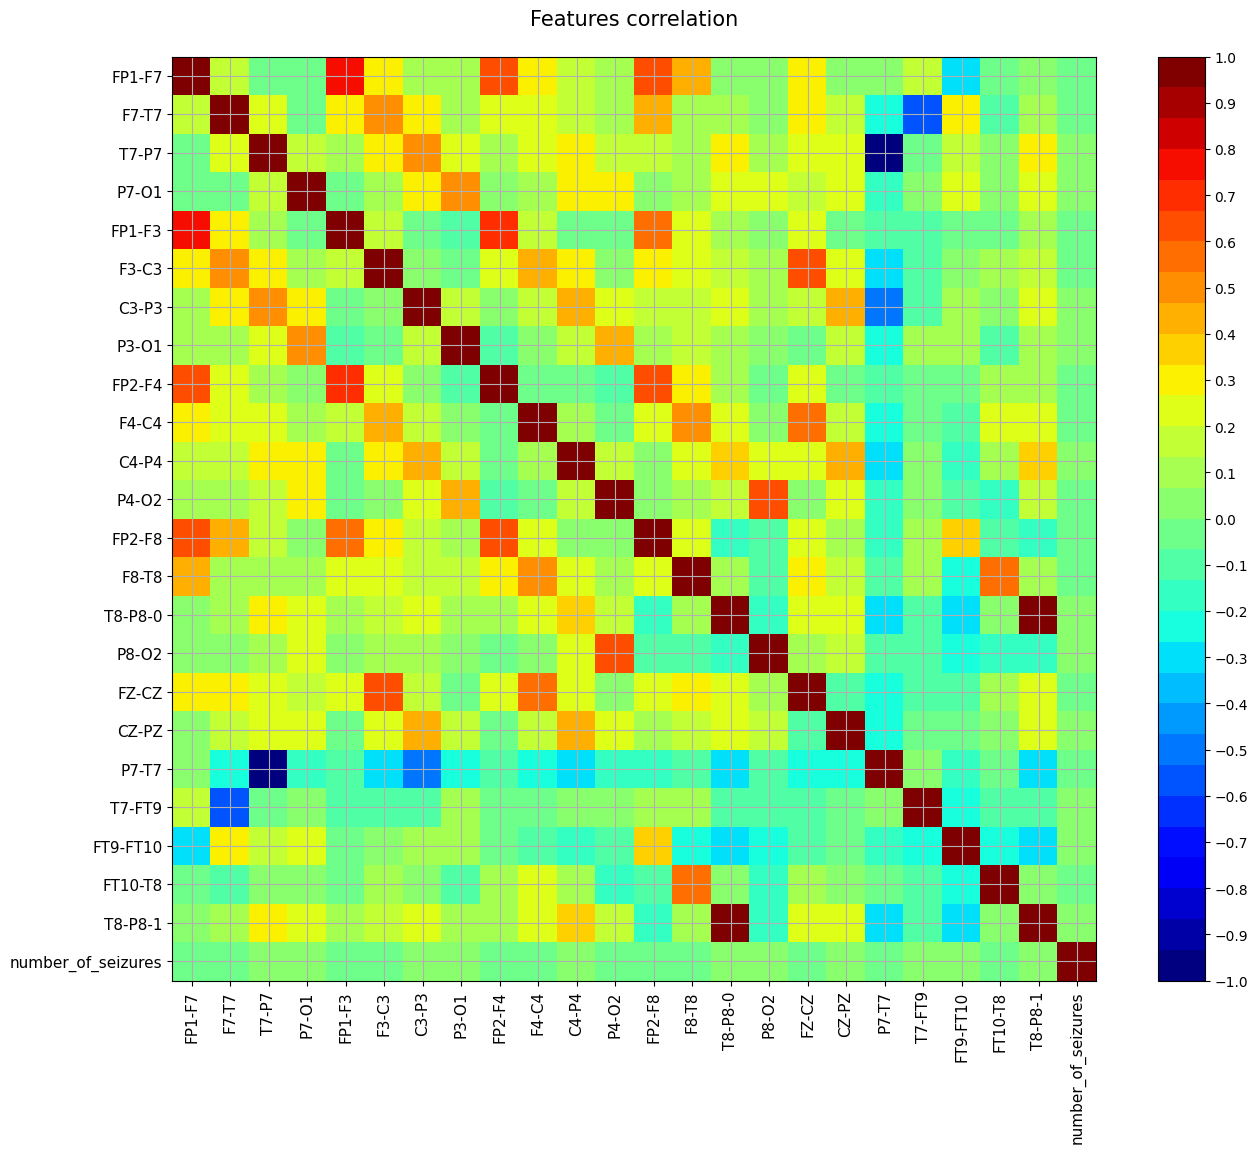

In [66]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Features correlation\n',fontsize=15)
    labels=df.columns
    ax1.set_xticks(np.arange(len(df.columns)))
    ax1.set_xticklabels(labels,fontsize=11, rotation=90)
    ax1.set_yticks(np.arange(len(df.columns)))
    ax1.set_yticklabels(labels,fontsize=11)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0.1*i for i in range(-11,11)])
    plt.show()

correlation_matrix(df)

/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


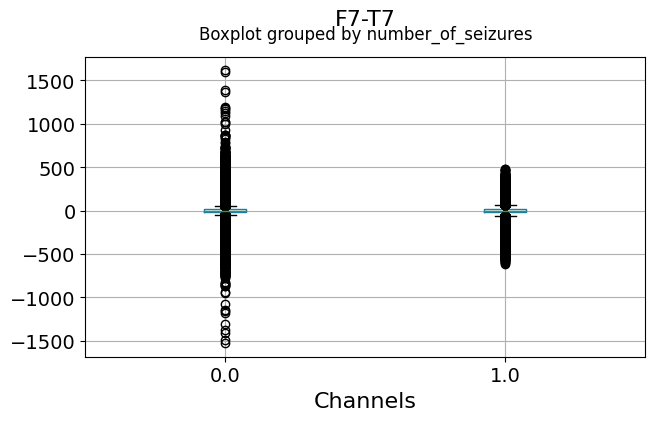

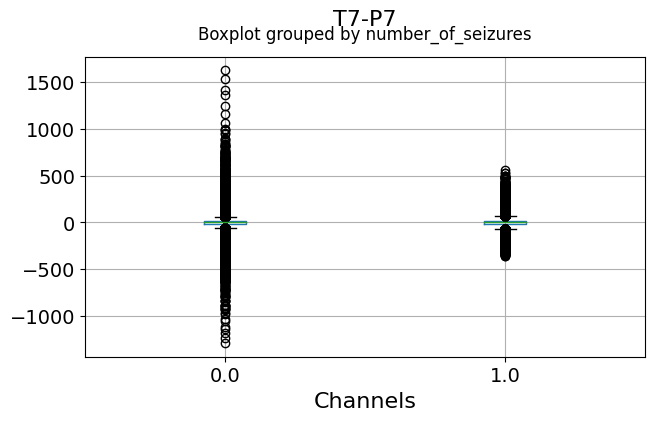

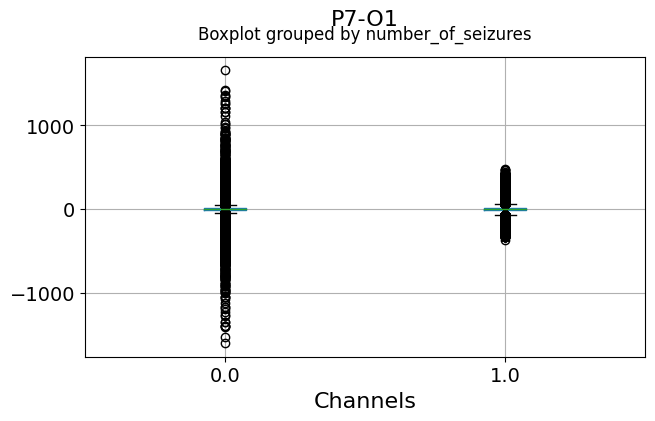

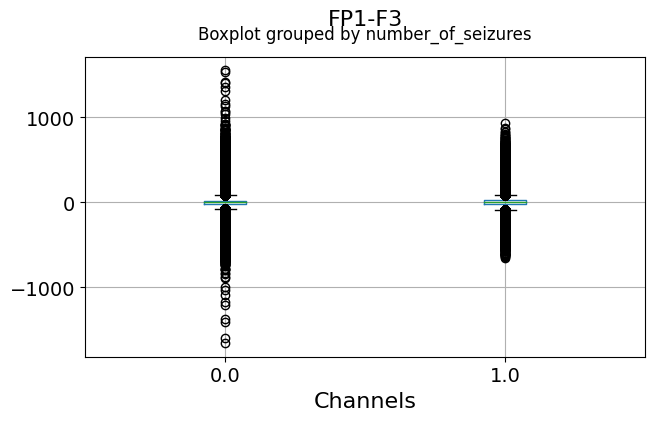

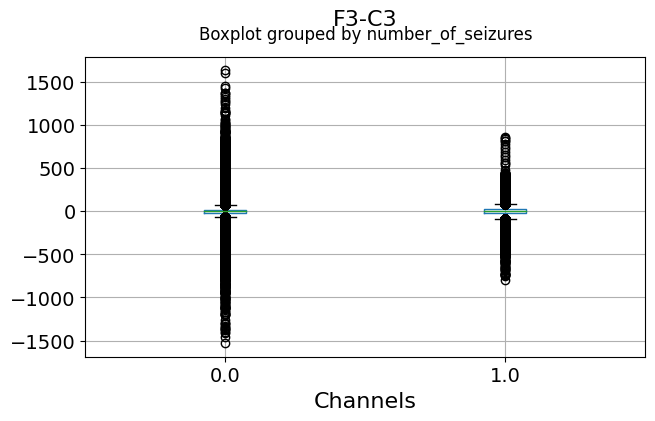

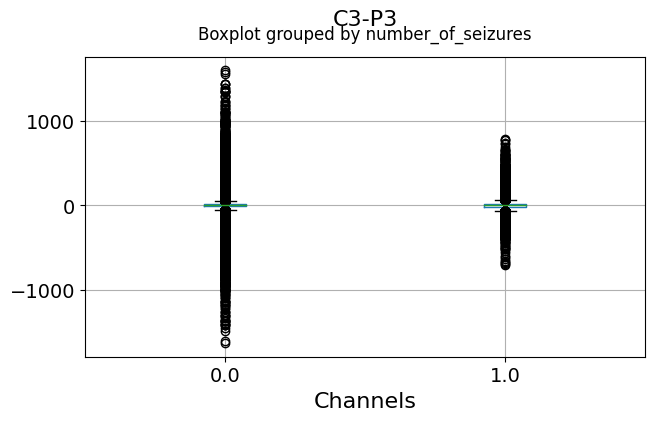

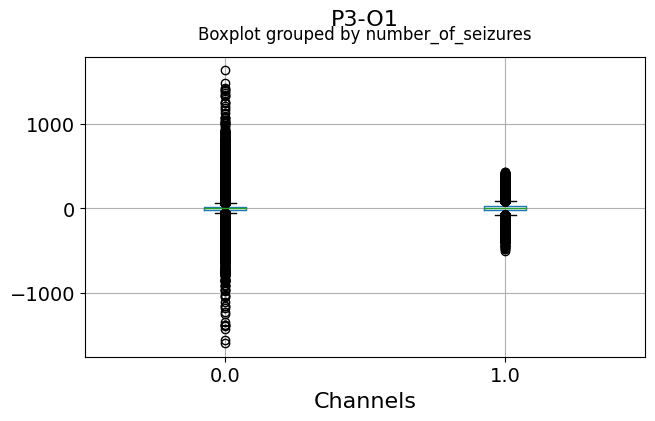

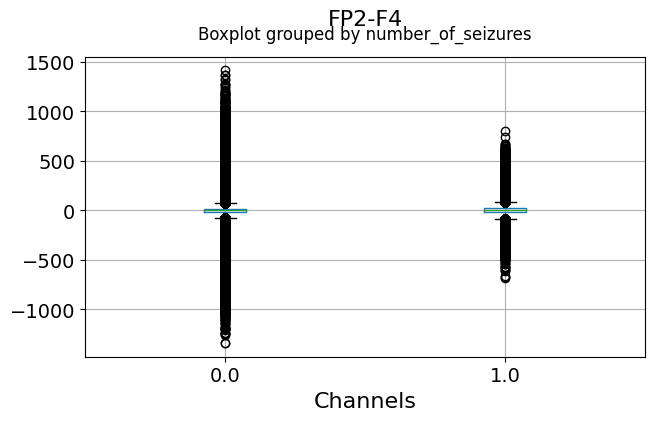

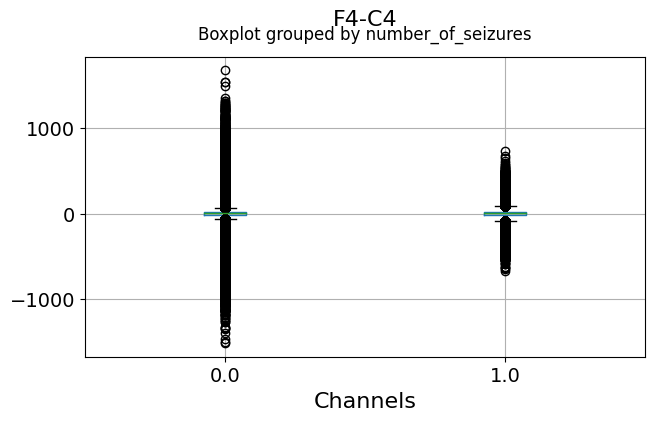

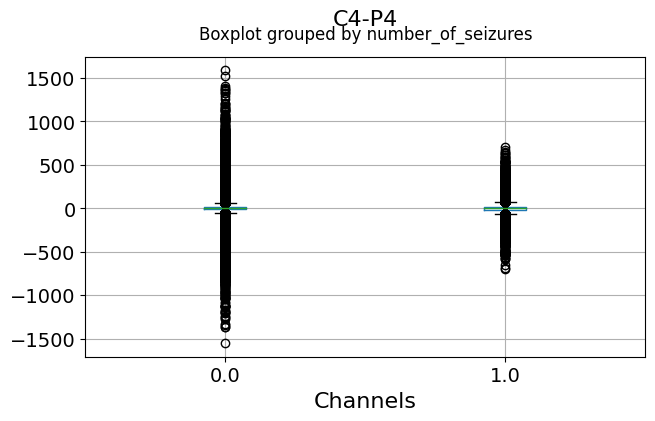

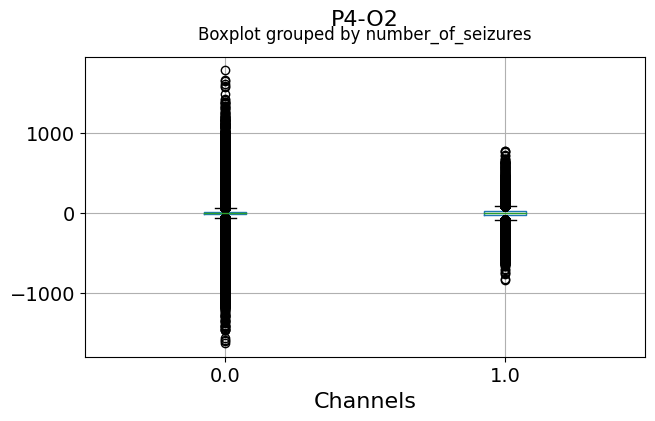

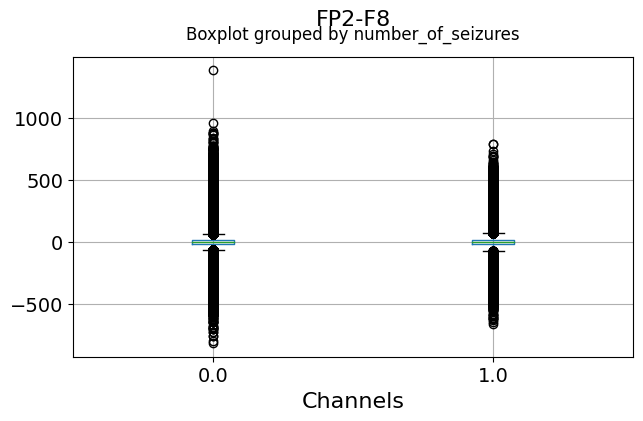

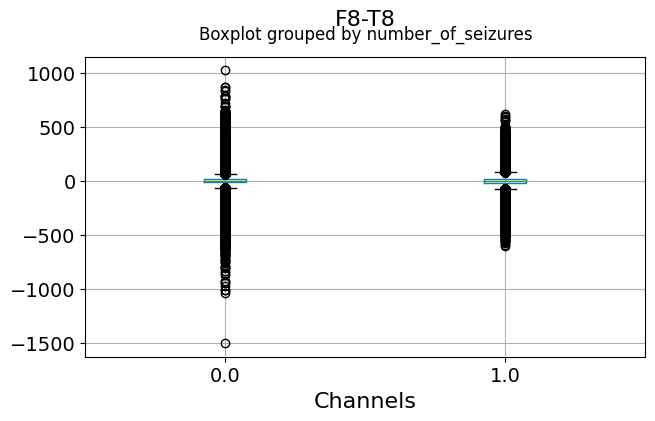

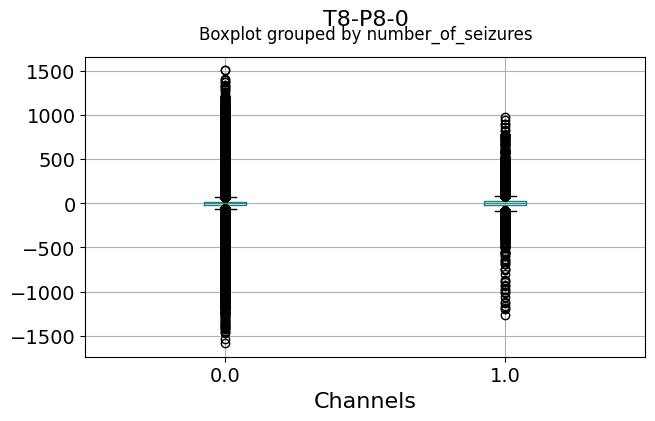

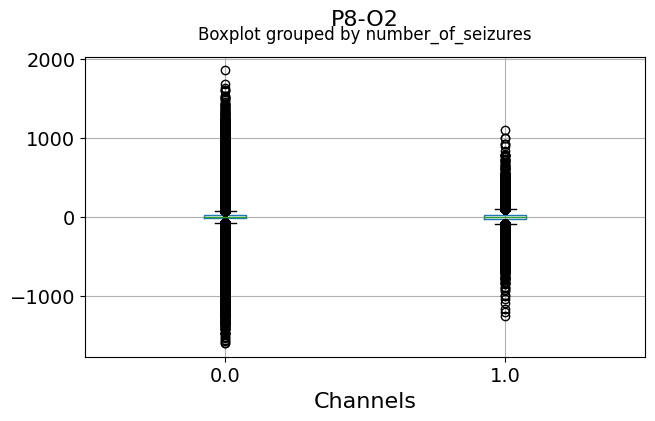

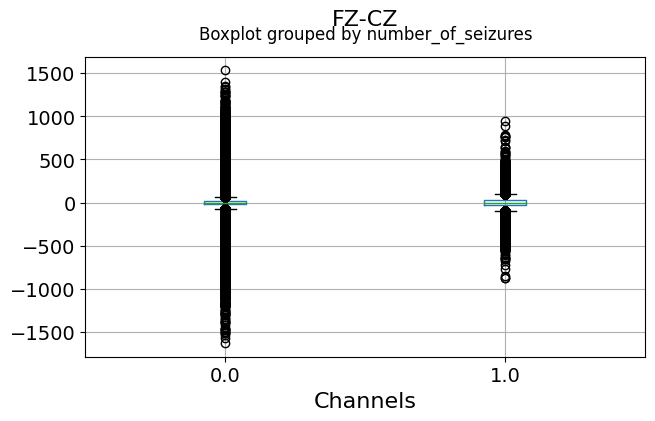

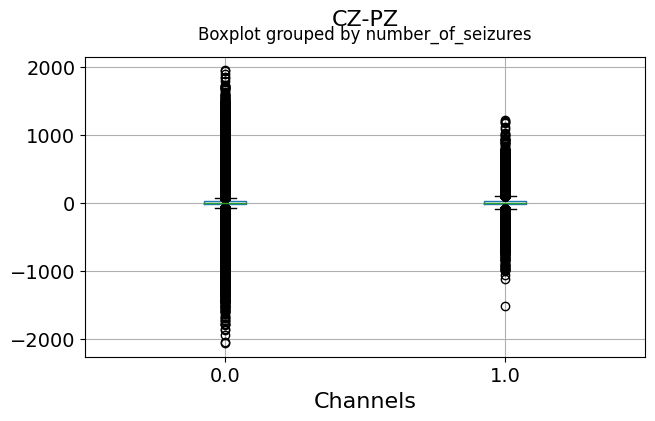

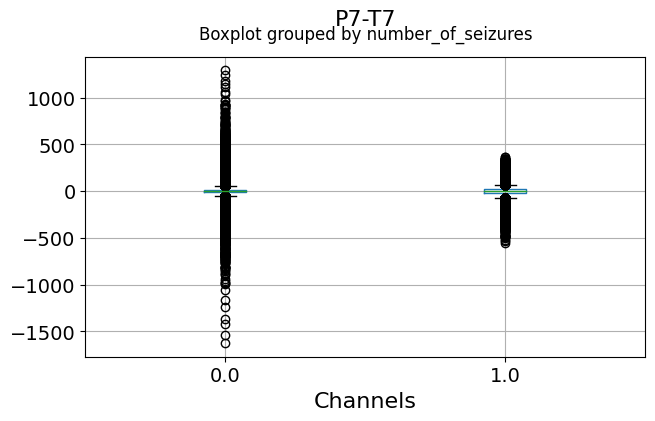

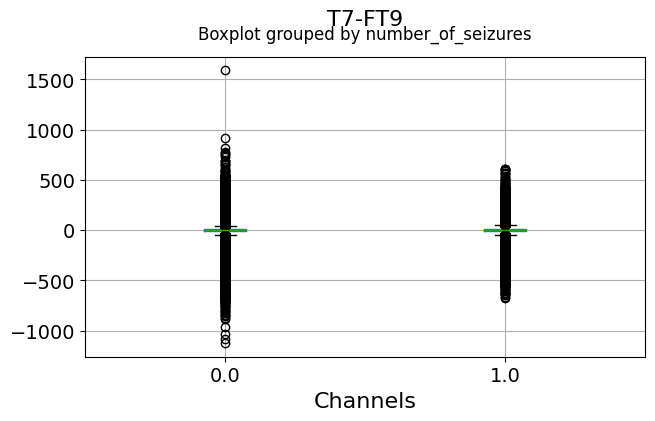

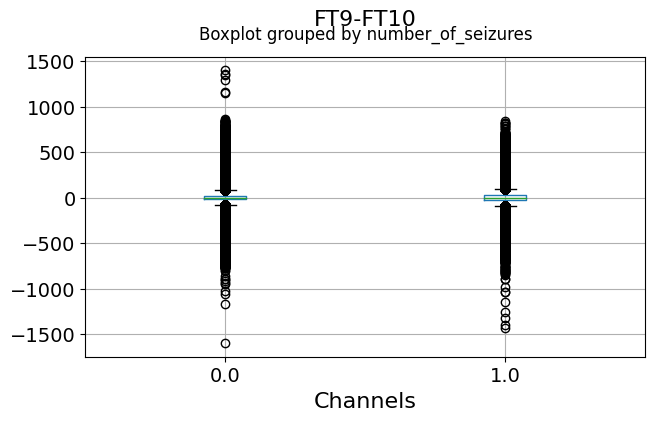

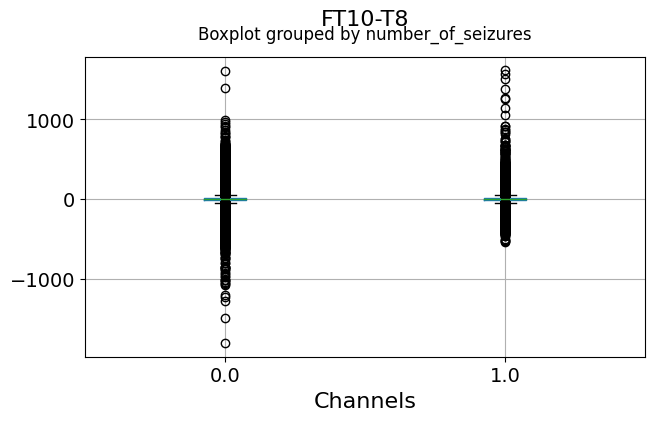

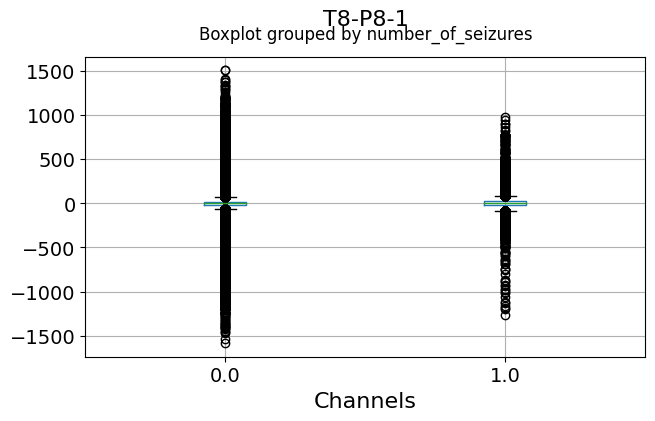

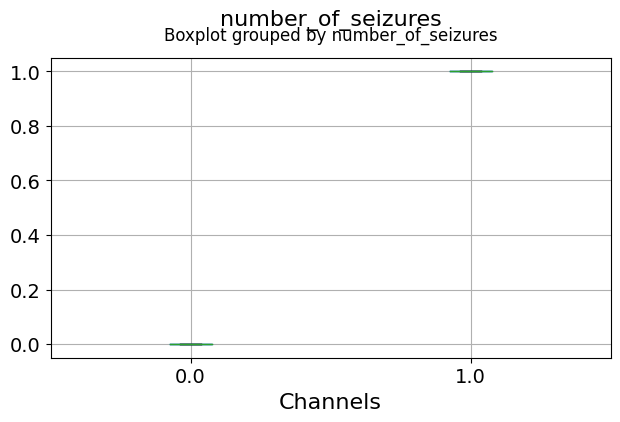

In [63]:
for c in df.columns[1:]:
    df.boxplot(c,by='number_of_seizures',figsize=(7,4),fontsize=14)
    plt.title("{}\n".format(c),fontsize=16)
    plt.xlabel("Channels", fontsize=16)

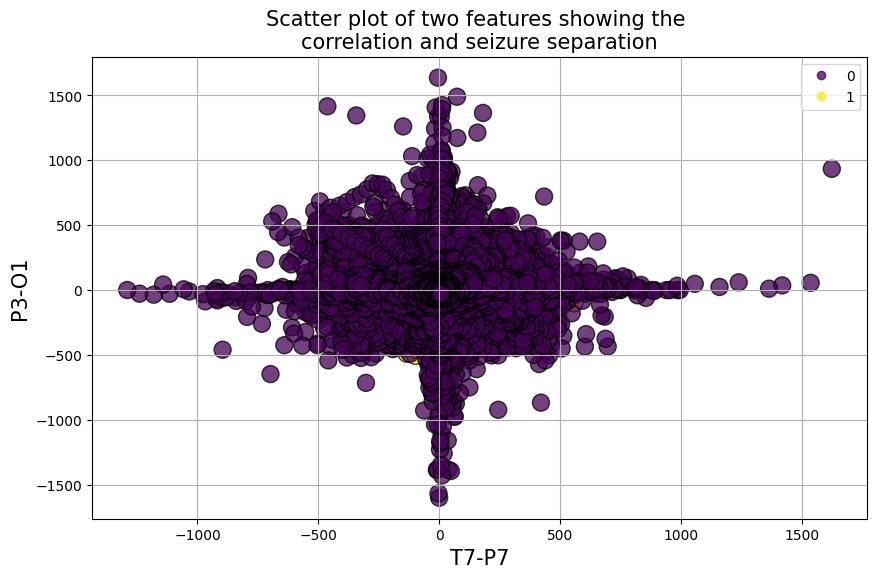

In [67]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(df['T7-P7'],df['P3-O1'],c=df['number_of_seizures'],edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
classes = ['0','1']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("Scatter plot of two features showing the \ncorrelation and seizure separation",fontsize=15)
plt.xlabel("T7-P7",fontsize=15)
plt.ylabel("P3-O1",fontsize=15)
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()

In [12]:
df_notime = df.drop(["number_of_seizures"], axis =1)

In [13]:
df_notime.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
0,-145.922954,-104.549989,-42.789594,-33.033629,-171.005805,-110.763096,11.944505,-56.473560,-139.200905,-1.391227,...,57.258465,44.710026,74.824216,-106.075114,84.603357,43.180314,-57.238740,-264.724467,94.771363,44.710026
1,24.324771,16.775379,8.051760,4.841834,28.174991,18.249390,-1.437435,8.941108,22.909189,0.551694,...,-10.804127,-7.175426,-8.432085,17.533853,-13.526526,-7.661039,11.152393,41.090696,-15.330497,-7.175426
2,-13.638932,-9.824394,-4.458138,-1.472269,-15.850114,-9.696507,0.512080,-4.037307,-11.617336,-0.477276,...,7.397012,4.714653,2.168167,-9.762120,7.473199,4.848859,-6.908725,-20.658354,9.004142,4.714653
3,11.697399,1.649078,6.754814,-3.704498,9.789924,6.142245,0.644558,0.095023,9.601437,-0.211472,...,-18.002764,-1.980045,25.032399,5.245805,-4.492231,-6.364093,16.697972,-5.111852,-6.596611,-1.980045
4,-7.006443,-49.644297,14.303701,-11.119439,-30.252343,-8.437790,-5.254385,-8.290752,8.168844,-13.337275,...,-40.235602,10.122724,86.319303,-21.902044,0.563564,-13.912981,37.581806,-65.840306,7.361782,10.122724


In [14]:
df_scaled = scaler.fit_transform(df_notime)
df_scaled = pd.DataFrame(data=df_scaled,columns=df_notime.columns)

In [29]:
df_scaled.describe()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
count,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,...,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07,1.167904e+07
mean,-6.041326e-18,-8.605544e-18,4.772222e-18,2.064120e-18,1.202972e-17,8.648284e-19,-3.239684e-19,1.464565e-17,4.175542e-18,5.091019e-18,...,2.103665e-18,-1.364801e-17,3.086522e-18,8.592007e-19,-5.684809e-18,1.190014e-18,-1.077248e-17,6.375714e-18,1.550189e-17,-1.364801e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.782689e+01,-4.261223e+01,-4.148291e+01,-5.613753e+01,-2.791528e+01,-3.885368e+01,-5.006458e+01,-4.666922e+01,-2.556102e+01,-3.729741e+01,...,-3.928396e+01,-3.514579e+01,-3.118923e+01,-3.744548e+01,-4.222808e+01,-5.221931e+01,-4.163485e+01,-2.916195e+01,-6.262688e+01,-3.514579e+01
25%,-2.989012e-01,-4.037817e-01,-4.666308e-01,-4.489550e-01,-3.631537e-01,-4.422140e-01,-4.336212e-01,-4.717846e-01,-3.860910e-01,-4.268765e-01,...,-4.454483e-01,-3.963291e-01,-3.646937e-01,-4.143753e-01,-4.035607e-01,-4.676587e-01,-4.271867e-01,-3.733858e-01,-4.272706e-01,-3.963291e-01
50%,-5.710846e-03,9.684226e-04,3.328051e-03,1.192456e-02,-6.299032e-03,2.761896e-03,-8.227305e-07,3.629527e-03,-1.078613e-02,5.157371e-03,...,-8.669792e-03,1.005209e-02,7.292008e-03,3.876427e-03,-1.810150e-03,-3.328051e-03,-5.637102e-04,-3.315145e-03,-3.148085e-03,1.005209e-02
75%,2.762153e-01,4.006717e-01,4.676587e-01,4.588086e-01,3.347162e-01,4.450095e-01,4.292879e-01,4.740588e-01,3.507290e-01,4.327713e-01,...,4.228679e-01,4.105323e-01,3.718786e-01,4.212457e-01,3.964387e-01,4.666308e-01,4.294155e-01,3.657245e-01,4.117948e-01,4.105323e-01
max,2.592659e+01,4.509642e+01,5.221931e+01,5.810745e+01,2.616400e+01,4.145558e+01,4.899638e+01,4.768708e+01,2.695931e+01,4.119132e+01,...,2.666804e+01,3.337125e+01,3.617393e+01,3.524916e+01,3.979478e+01,4.148291e+01,5.888239e+01,2.547893e+01,5.594229e+01,3.337125e+01


In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=None)

In [17]:
df_pca = pca.fit(df_scaled)

In [ ]:
df_pca.explained_variance_

array([1.04837932e+04, 6.35997362e+03, 4.65355316e+03, 4.03002159e+03,
       2.92177402e+03, 2.45228508e+03, 1.85996530e+03, 1.50245327e+03,
       1.29991241e+03, 1.24780168e+03, 9.62735675e+02, 8.86061948e+02,
       7.82967488e+02, 6.07291789e+02, 5.29372512e+02, 3.66057500e+02,
       3.22899545e+02, 2.71106220e+02, 9.73016013e+01, 1.34830241e-01,
       9.55093347e-02, 2.64214607e-27, 3.83103657e-29])

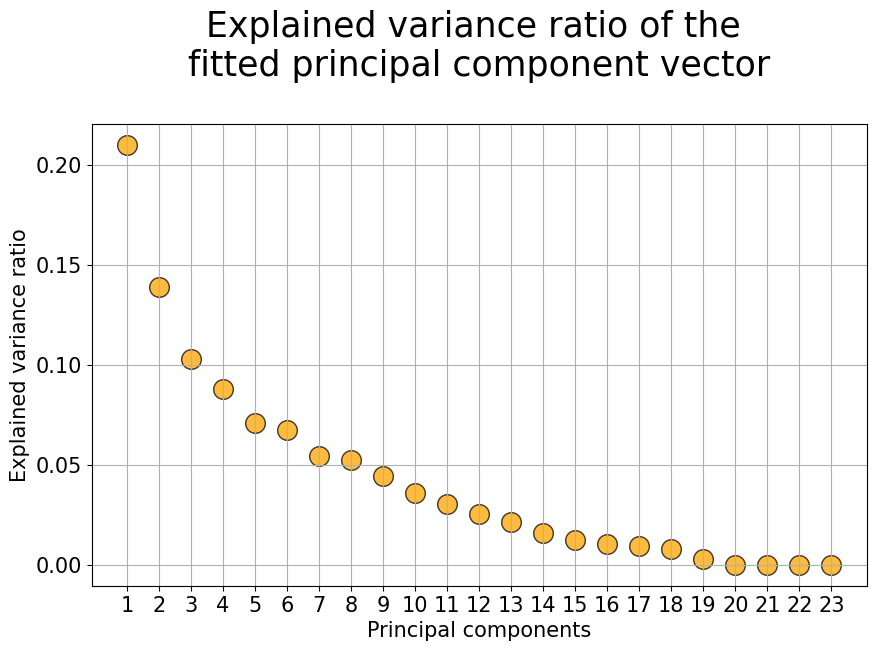

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_pca.explained_variance_ratio_))],
            y=df_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [19]:
df_trans = pca.transform(df_notime)
df_trans = pd.DataFrame(data=df_trans)
df_trans.head(10)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-182.795335,-315.048154,-300.497516,-6.531907,-123.014398,38.744941,-133.117189,-124.083723,60.261698,23.509869,...,70.811351,-11.635593,-7.200172,45.490342,23.866389,57.201119,11.838338,0.301201,0.001078,0.276279
1,31.342151,50.510891,49.081883,-2.334198,19.800175,-4.558304,23.719852,17.345533,-8.880610,-3.431674,...,-11.652999,3.701562,0.773351,-7.553082,-4.721688,-9.493775,-1.800598,-0.390616,0.001078,0.276279
2,-16.907230,-27.657853,-27.462272,2.854227,-10.020245,0.691025,-14.299438,-6.844324,4.591576,0.745817,...,6.020572,-3.044691,-0.524345,4.390649,3.674744,4.896498,0.618262,0.562374,0.001078,0.276279
3,15.183559,11.587186,16.251336,-27.411822,7.129371,14.751468,23.425775,-15.879301,3.919568,2.057425,...,-2.957482,16.482386,-3.545299,-4.374729,-6.345486,-2.215473,1.152784,-2.935322,0.001078,0.276279
4,-11.668548,-53.456743,-23.677157,-87.401513,9.336349,37.187715,45.681813,-67.937516,36.288869,-3.459191,...,-2.250716,48.344968,-21.076870,-4.262513,8.192381,7.844885,6.830971,-6.019940,0.001078,0.276279
5,-12.260961,-14.775080,-33.260997,-56.075880,9.123143,44.114840,25.757532,-25.800558,32.592594,17.053909,...,-2.822888,32.865528,2.337922,-14.456002,-9.521476,0.033514,3.772030,-2.735020,0.001078,0.276279
6,-15.863510,-5.796894,-16.541660,-57.139855,-4.996716,17.665168,40.521746,-45.443980,19.879878,1.477723,...,-16.590385,43.940096,-10.324943,-3.373134,4.404396,2.364557,5.324628,-3.471794,0.001078,0.276279
7,3.370358,39.080649,18.075587,-22.845761,6.931161,23.241375,28.740245,-2.152013,-2.116605,-0.874511,...,-3.213481,42.520100,-6.575148,-7.160852,12.370841,-8.639495,6.372274,1.273820,0.001078,0.276279
8,-9.668215,34.212198,17.054801,-18.267186,-2.262408,-1.693587,59.048399,-15.998839,7.416509,-0.358631,...,0.064629,37.895577,14.747645,-14.416254,13.660440,-10.811117,4.540649,0.816835,0.001078,0.276279
9,-30.088136,57.192930,44.321071,14.929375,15.856471,-26.711452,43.303236,39.199714,16.900115,-13.162616,...,-6.124464,25.670108,3.934028,-10.989347,14.998703,-16.102586,0.786075,6.317898,0.001078,0.276279


In [60]:
df.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1,number_of_seizures
0,-145.922954,-104.549989,-42.789594,-33.033629,-171.005805,-110.763096,11.944505,-56.473560,-139.200905,-1.391227,...,44.710026,74.824216,-106.075114,84.603357,43.180314,-57.238740,-264.724467,94.771363,44.710026,0.0
1,24.324771,16.775379,8.051760,4.841834,28.174991,18.249390,-1.437435,8.941108,22.909189,0.551694,...,-7.175426,-8.432085,17.533853,-13.526526,-7.661039,11.152393,41.090696,-15.330497,-7.175426,0.0
2,-13.638932,-9.824394,-4.458138,-1.472269,-15.850114,-9.696507,0.512080,-4.037307,-11.617336,-0.477276,...,4.714653,2.168167,-9.762120,7.473199,4.848859,-6.908725,-20.658354,9.004142,4.714653,0.0
3,11.697399,1.649078,6.754814,-3.704498,9.789924,6.142245,0.644558,0.095023,9.601437,-0.211472,...,-1.980045,25.032399,5.245805,-4.492231,-6.364093,16.697972,-5.111852,-6.596611,-1.980045,0.0
4,-7.006443,-49.644297,14.303701,-11.119439,-30.252343,-8.437790,-5.254385,-8.290752,8.168844,-13.337275,...,10.122724,86.319303,-21.902044,0.563564,-13.912981,37.581806,-65.840306,7.361782,10.122724,0.0


In [20]:
y= df.number_of_seizures

In [61]:
y.unique()

array([0., 1.])

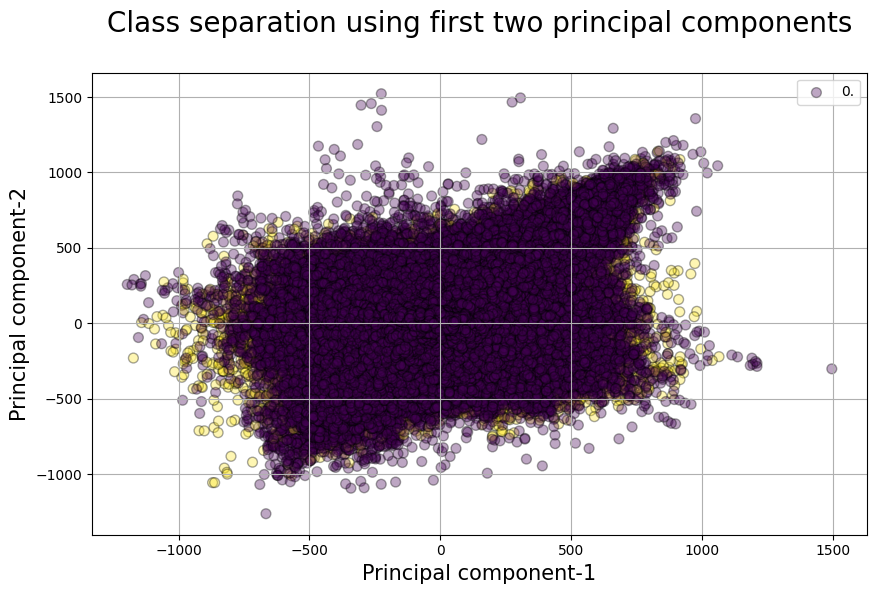

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(df_trans[0],df_trans[1],c=y,edgecolors='k',alpha=0.35,s=50)
classes = ['0.', '1.']
plt.legend(labels=classes)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [ ]:
# This function adds if a timestamp is in a seizure sequence
def assign_seizures(final_df, seizures_df):
    final_df["Seizure"] = 0
    
    # Iterate through each row in participants_df and check if 'original_time' is within any seizure range
    for index, row in final_df.iterrows():
        file_name = row["file_name"]
        original_time = row["original_time"]
        matching_seizure = seizures_df[(seizures_df["file_name"] == file_name) & (seizures_df["Seizure Start Time"] <= original_time) & (seizures_df["Seizure End Time"] >= original_time)]
        
        if not matching_seizure.empty:
            final_df.at[index, "Seizure"] = 1
    
    return final_df